# Baseline model
## Introduction
This notebook contains the baseline model that we need to outperform. The baseline model is a weighted average (seasonal) timeseries forecast for the next 4 quarters.

The data is limited to 2014 and onwards, so that we have a prediction for the last 10 years (2015-2025). This can be changed by adjusting the where clause in the SQL statement.

In the bottom section of the notebook the baseline prediction is visualised for three groups of SBI codes:
- Total aggregated absenteeism (sbi=T001081)
- Absenteeism per SBI category (sbi lvl1, category A, B C etc.)
- Absenteeism per company size (sbi=WP19098,WP19091, WP19078)

## Data preparation

In [83]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sqlalchemy import create_engine  # ← add this line
from pathlib import Path
from config import DIR_DB_SILVER

# Settings
pl.Config(
    tbl_cols=-1,        # Show all columns
    tbl_rows=20,        # Show 20 rows
    tbl_width_chars=10000  # Prevent truncation due to width limit
)
# --- Database Connection ---
# Check if database exists; handle both root and 'code' directory execution
if not DIR_DB_SILVER.exists():
    if (Path("..") / DIR_DB_SILVER).exists():
        DIR_DB_SILVER = Path("..") / DIR_DB_SILVER
    else:
        raise FileNotFoundError(f"❌ Database not found at {DIR_DB_SILVER}. Ensure you are in the project root.")

# Create a simple SQLAlchemy engine for the Silver database
engine = create_engine(f"sqlite:///{DIR_DB_SILVER}")

# SQL Query to extract and format absenteeism data
query = """
SELECT 
    Perioden as timeperiod_text, 
    BedrijfskenmerkenSBI2008  as sbi_code,
    BedrijfskenmerkenSBI2008_Title as sbi_title,
    DATE(
        printf('%s-%s-01', 
            substr(Perioden, 1, 4), 
            CASE substr(Perioden, 7, 2)
                WHEN '01' THEN '01'
                WHEN '02' THEN '04'
                WHEN '03' THEN '07'
                WHEN '04' THEN '10'
            END
        ), 
        '+3 months', 
        '-1 day'
    ) AS period_enddate,
    CAST(substr(Perioden, 1, 4) as INTEGER) as "year",
    CAST(substr(Perioden, 8, 1) as INTEGER) as "quarter",
    CAST(Ziekteverzuimpercentage_1 AS REAL) as absenteeism_perc
FROM "80072ned_silver"
WHERE Perioden NOT LIKE '%JJ%' 
AND substr(Perioden, 1, 4) >= '2014'
order by sbi_code, Period_enddate asc
"""

# Load into Polars DataFrame
with engine.connect() as conn:
    df_org = pl.read_database(query=query, connection=conn)

print(f"✅ Success! Loaded {len(df_org)} rows.")
df_org.head()

✅ Success! Loaded 1833 rows.


shape: (5, 7)
┌─────────────────┬──────────┬───────────────────────────┬────────────────┬──────┬─────────┬──────────────────┐
│ timeperiod_text ┆ sbi_code ┆ sbi_title                 ┆ period_enddate ┆ year ┆ quarter ┆ absenteeism_perc │
│ ---             ┆ ---      ┆ ---                       ┆ ---            ┆ ---  ┆ ---     ┆ ---              │
│ str             ┆ str      ┆ str                       ┆ str            ┆ i64  ┆ i64     ┆ f64              │
╞═════════════════╪══════════╪═══════════════════════════╪════════════════╪══════╪═════════╪══════════════════╡
│ 2014KW01        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2014-03-31     ┆ 2014 ┆ 1       ┆ 4.5              │
│ 2014KW02        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2014-06-30     ┆ 2014 ┆ 2       ┆ 4.3              │
│ 2014KW03        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2014-09-30     ┆ 2014 ┆ 3       ┆ 4.1              │
│ 2014KW04        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2014-12-31     ┆ 2014 ┆ 4       ┆ 4.7              │
│ 2015KW01        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2015-03-31     ┆ 2015 ┆ 1       ┆ 5.1              │
└─────────────────┴──────────┴───────────────────────────┴────────────────┴──────┴─────────┴──────────────────┘

In [ ]:
df_modified = df_org.with_columns(
    # Convert columns ending with 'date' to Date type
    cs.ends_with("date").str.to_date("%Y-%m-%d"),
)
df_modified.sort("period_enddate", descending=True).head()

shape: (5, 7)
┌─────────────────┬──────────┬─────────────────────────────────┬────────────────┬──────┬─────────┬──────────────────┐
│ timeperiod_text ┆ sbi_code ┆ sbi_title                       ┆ period_enddate ┆ year ┆ quarter ┆ absenteeism_perc │
│ ---             ┆ ---      ┆ ---                             ┆ ---            ┆ ---  ┆ ---     ┆ ---              │
│ str             ┆ str      ┆ str                             ┆ date           ┆ i64  ┆ i64     ┆ f64              │
╞═════════════════╪══════════╪═════════════════════════════════╪════════════════╪══════╪═════════╪══════════════════╡
│ 2025KW03        ┆ 300003   ┆ B-F Nijverheid en energie       ┆ 2025-09-30     ┆ 2025 ┆ 3       ┆ 5.4              │
│ 2025KW03        ┆ 300007   ┆ G-N Commerciële dienstverlenin… ┆ 2025-09-30     ┆ 2025 ┆ 3       ┆ 4.3              │
│ 2025KW03        ┆ 300013   ┆ O-U Niet-commerciële dienstver… ┆ 2025-09-30     ┆ 2025 ┆ 3       ┆ 6.1              │
│ 2025KW03        ┆ 301000   ┆ A Landbouw, bosbouw en visseri… ┆ 2025-09-30     ┆ 2025 ┆ 3       ┆ 3.3              │
│ 2025KW03        ┆ 305700   ┆ B Delfstoffenwinning            ┆ 2025-09-30     ┆ 2025 ┆ 3       ┆ 5.0              │
└─────────────────┴──────────┴─────────────────────────────────┴────────────────┴──────┴─────────┴──────────────────┘

: 

: 

#### Year-on-Year Moving Average Prediction Model
**Goal:** <br> For each quarter (Q1/Q2/Q3/Q4) and sbi_code, calculate a rolling 3-year moving average of Absenteeism_perc as a simple prediction.
Example: The prediction for Q1-2019 = average of Q1-2016, Q1-2017, Q1-2018.

**Step 1: Sort the Data** <br>
Polars window functions respect row order, so we must sort by sbi_code, quarter, and year to ensure the rolling average looks back over the correct preceding years (e.g. 2016 → 2017 → 2018 for a Q1 prediction of 2019).

In [ ]:
df_sorted = df_modified.sort(["sbi_code", "quarter", "year"])
df_sorted.head()

shape: (5, 7)
┌─────────────────┬──────────┬───────────────────────────┬────────────────┬──────┬─────────┬──────────────────┐
│ timeperiod_text ┆ sbi_code ┆ sbi_title                 ┆ period_enddate ┆ year ┆ quarter ┆ absenteeism_perc │
│ ---             ┆ ---      ┆ ---                       ┆ ---            ┆ ---  ┆ ---     ┆ ---              │
│ str             ┆ str      ┆ str                       ┆ date           ┆ i64  ┆ i64     ┆ f64              │
╞═════════════════╪══════════╪═══════════════════════════╪════════════════╪══════╪═════════╪══════════════════╡
│ 2014KW01        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2014-03-31     ┆ 2014 ┆ 1       ┆ 4.5              │
│ 2015KW01        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2015-03-31     ┆ 2015 ┆ 1       ┆ 5.1              │
│ 2016KW01        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2016-03-31     ┆ 2016 ┆ 1       ┆ 5.1              │
│ 2017KW01        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2017-03-31     ┆ 2017 ┆ 1       ┆ 4.9              │
│ 2018KW01        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2018-03-31     ┆ 2018 ┆ 1       ┆ 5.6              │
└─────────────────┴──────────┴───────────────────────────┴────────────────┴──────┴─────────┴──────────────────┘

: 

: 

**Step 2: Calculate the Rolling 3-Year Moving Average per Quarter and sbi_code** <br>
Let $\hat{y}_{t}$ be the predicted absenteeism rate for the current quarter, and $y_{t-n}$ be the actual quartly absenteeism rate from $n$ years ago, the formula is:$$\hat{y}_{t} = \frac{y_{t-1} + y_{t-2} + y_{t-3}}{3}$$(Where $t$ represents the same quarter in previous years).

We use .over(["sbi_code", "quarter"]) to partition the data into groups, so the rolling average is calculated independently for each unique combination of sbi_code and Quarter (e.g. all Q1 rows for sbi_code "A").

Explanation of the calculation:<br>
- shift(1): This prevents "Look-ahead Bias." It ensures that the value for the current row is ignored, and the window starts from the previous year's data
- window_size=3: averages the 3 most recent years for that quarter *starting from the previous year's data*
- min_periods=1 — allows the average to be computed even when fewer than 3 years of history are available (e.g. the first year in the data)

In [ ]:
# 1. Apply the shift and rolling mean within the seasonal groups
df_baseline = df_sorted.with_columns(
    pl.col("absenteeism_perc")
    .shift(1) # Moves previous years' data into the current year's row
    .rolling_mean(window_size=3, min_samples=1)
    .over(["sbi_code", "quarter"]) # Ensures we only average the same quarter across years
    .alias("baseline_prediction")
)
# 2. Calculate the Residual (Error) to evaluate the baseline
df_baseline = df_baseline.with_columns(
    (pl.col("absenteeism_perc") - pl.col("baseline_prediction")).alias("residual_error")
    ).with_columns(pl.col("residual_error").abs().alias("abs_error"))
# Preview the results ordered by period_enddate
df_baseline.sort(["sbi_code", "period_enddate"]).head(10)

# Uncomment to preview the results for a specific sbi_code
# df_baseline.filter(pl.col("sbi_code") == "301000").sort("period_enddate").head(43)

shape: (10, 10)
┌─────────────────┬──────────┬───────────────────────────┬────────────────┬──────┬─────────┬──────────────────┬─────────────────────┬────────────────┬───────────┐
│ timeperiod_text ┆ sbi_code ┆ sbi_title                 ┆ period_enddate ┆ year ┆ quarter ┆ absenteeism_perc ┆ baseline_prediction ┆ residual_error ┆ abs_error │
│ ---             ┆ ---      ┆ ---                       ┆ ---            ┆ ---  ┆ ---     ┆ ---              ┆ ---                 ┆ ---            ┆ ---       │
│ str             ┆ str      ┆ str                       ┆ date           ┆ i64  ┆ i64     ┆ f64              ┆ f64                 ┆ f64            ┆ f64       │
╞═════════════════╪══════════╪═══════════════════════════╪════════════════╪══════╪═════════╪══════════════════╪═════════════════════╪════════════════╪═══════════╡
│ 2014KW01        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2014-03-31     ┆ 2014 ┆ 1       ┆ 4.5              ┆ null                ┆ null           ┆ null      │
│ 2014KW02        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2014-06-30     ┆ 2014 ┆ 2       ┆ 4.3              ┆ null                ┆ null           ┆ null      │
│ 2014KW03        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2014-09-30     ┆ 2014 ┆ 3       ┆ 4.1              ┆ null                ┆ null           ┆ null      │
│ 2014KW04        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2014-12-31     ┆ 2014 ┆ 4       ┆ 4.7              ┆ null                ┆ null           ┆ null      │
│ 2015KW01        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2015-03-31     ┆ 2015 ┆ 1       ┆ 5.1              ┆ 4.5                 ┆ 0.6            ┆ 0.6       │
│ 2015KW02        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2015-06-30     ┆ 2015 ┆ 2       ┆ 4.3              ┆ 4.3                 ┆ 0.0            ┆ 0.0       │
│ 2015KW03        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2015-09-30     ┆ 2015 ┆ 3       ┆ 4.0              ┆ 4.1                 ┆ -0.1           ┆ 0.1       │
│ 2015KW04        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2015-12-31     ┆ 2015 ┆ 4       ┆ 4.5              ┆ 4.7                 ┆ -0.2           ┆ 0.2       │
│ 2016KW01        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2016-03-31     ┆ 2016 ┆ 1       ┆ 5.1              ┆ 4.8                 ┆ 0.3            ┆ 0.3       │
│ 2016KW02        ┆ 300003   ┆ B-F Nijverheid en energie ┆ 2016-06-30     ┆ 2016 ┆ 2       ┆ 4.3              ┆ 4.3                 ┆ 0.0            ┆ 0.0       │
└─────────────────┴──────────┴───────────────────────────┴────────────────┴──────┴─────────┴──────────────────┴─────────────────────┴────────────────┴───────────┘

: 

: 

**Split dataset into three seperate dataframes** <br>
- df_total: containing the total absenteeism as calculated by the CBS
- df_sbi_lvl1: containing the absenteeism grouped by the first SBI code level [A-U]
- df_compsize: containing the absenteeism grouped by company size

In [ ]:
df_total = df_baseline.filter(pl.col("sbi_code") == "T001081")
df_sbi_lvl1 = df_baseline.filter(pl.col("sbi_title").str.to_uppercase().str.contains(r"^[A-U]\s"))
df_compsize = df_baseline.filter(pl.col("sbi_code") .is_in(["WP19098", "WP19091", "WP19078"]))

df_total.head()
#df_sbi_lvl1.head(10)
#df_compsize.head()

shape: (5, 10)
┌─────────────────┬──────────┬─────────────────────────────────┬────────────────┬──────┬─────────┬──────────────────┬─────────────────────┬────────────────┬───────────┐
│ timeperiod_text ┆ sbi_code ┆ sbi_title                       ┆ period_enddate ┆ year ┆ quarter ┆ absenteeism_perc ┆ baseline_prediction ┆ residual_error ┆ abs_error │
│ ---             ┆ ---      ┆ ---                             ┆ ---            ┆ ---  ┆ ---     ┆ ---              ┆ ---                 ┆ ---            ┆ ---       │
│ str             ┆ str      ┆ str                             ┆ date           ┆ i64  ┆ i64     ┆ f64              ┆ f64                 ┆ f64            ┆ f64       │
╞═════════════════╪══════════╪═════════════════════════════════╪════════════════╪══════╪═════════╪══════════════════╪═════════════════════╪════════════════╪═══════════╡
│ 2014KW01        ┆ T001081  ┆ A-U Alle economische activitei… ┆ 2014-03-31     ┆ 2014 ┆ 1       ┆ 4.0              ┆ null                ┆ null           ┆ null      │
│ 2015KW01        ┆ T001081  ┆ A-U Alle economische activitei… ┆ 2015-03-31     ┆ 2015 ┆ 1       ┆ 4.4              ┆ 4.0                 ┆ 0.4            ┆ 0.4       │
│ 2016KW01        ┆ T001081  ┆ A-U Alle economische activitei… ┆ 2016-03-31     ┆ 2016 ┆ 1       ┆ 4.3              ┆ 4.2                 ┆ 0.1            ┆ 0.1       │
│ 2017KW01        ┆ T001081  ┆ A-U Alle economische activitei… ┆ 2017-03-31     ┆ 2017 ┆ 1       ┆ 4.3              ┆ 4.233333            ┆ 0.066667       ┆ 0.066667  │
│ 2018KW01        ┆ T001081  ┆ A-U Alle economische activitei… ┆ 2018-03-31     ┆ 2018 ┆ 1       ┆ 4.9              ┆ 4.333333            ┆ 0.566667       ┆ 0.566667  │
└─────────────────┴──────────┴─────────────────────────────────┴────────────────┴──────┴─────────┴──────────────────┴─────────────────────┴────────────────┴───────────┘

: 

: 

## Evaluation
To calculate the Mean Absolute Error (MAE), we need to determine how far off our predictions are from the actual values on average, regardless of whether the prediction was too high or too low. By taking the Absolute Value, we ensure every "miss" is treated as a positive distance from the truth.

In [ ]:
# 1. Calculate the Global MAE-s
total_mae = df_total.select(pl.col("abs_error").mean()).item()

print(f"Global Mean Absolute Error: {total_mae:.4f}")

# 2. Calculate MAE per SBI_code (Industry)
# This helps identify if the baseline works better for some industries than others
mae_per_industry = (
    df_sbi_lvl1
    .group_by("sbi_code")
    .agg(
        pl.col("abs_error").mean().alias("mae")
    )
    .sort("mae")
)
# 2. Calculate MAE per company size
mae_per_compsize = (
    df_compsize
    .group_by("sbi_code")
    .agg(
        pl.col("abs_error").mean().alias("mae")
    )
    .sort("mae")
)
# Convert MAE per industry to a dict for easy lookup
mae_dict_sbi = dict(zip(mae_per_industry["sbi_code"].to_list(), mae_per_industry["mae"].to_list()))
# Convert MAE per company size to a dict for easy lookup
mae_dict_compsize = dict(zip(mae_per_compsize["sbi_code"].to_list(), mae_per_compsize["mae"].to_list()))
print(mae_per_industry.head())
print(mae_per_compsize.head())

Global Mean Absolute Error: 0.3027
shape: (5, 2)
┌──────────┬──────────┐
│ sbi_code ┆ mae      │
│ ---      ┆ ---      │
│ str      ┆ f64      │
╞══════════╪══════════╡
│ 403300   ┆ 0.239535 │
│ 419000   ┆ 0.250388 │
│ 391600   ┆ 0.26124  │
│ 396300   ┆ 0.296899 │
│ 410200   ┆ 0.297287 │
└──────────┴──────────┘
shape: (3, 2)
┌──────────┬──────────┐
│ sbi_code ┆ mae      │
│ ---      ┆ ---      │
│ str      ┆ f64      │
╞══════════╪══════════╡
│ WP19091  ┆ 0.306589 │
│ WP19098  ┆ 0.324419 │
│ WP19078  ┆ 0.47093  │
└──────────┴──────────┘


: 

: 

## Visualisation
**Step 1: Prepare the Data for Plotting** <br>
Polars dataframes need to be converted to Pandas for Seaborn to work with them. We also sort by date to ensure the lines are drawn in chronological order.

In [ ]:
# Function to convert Polars dataframe to Pandas and sort chronologically for correct line drawing
# because seaborn works with Pandas
def to_plot_df(df: pl.DataFrame) -> pd.DataFrame:
    return (
        df
        .select(["timeperiod_text", "period_enddate", "sbi_code", "sbi_title", "baseline_prediction", "absenteeism_perc", "abs_error"])
        .drop_nulls()  # Remove the first year per group, which has no prediction due to the shift
        .to_pandas()
        .sort_values(["sbi_code", "period_enddate"])
        .reset_index(drop=True)
    )

df_plot_total    = to_plot_df(df_total)
df_plot_sbi      = to_plot_df(df_sbi_lvl1)
df_plot_compsize = to_plot_df(df_compsize)

df_plot_total.head(10)

timeperiod_text period_enddate sbi_code                          sbi_title  \
0        2015KW01     2015-03-31  T001081  A-U Alle economische activiteiten   
1        2015KW02     2015-06-30  T001081  A-U Alle economische activiteiten   
2        2015KW03     2015-09-30  T001081  A-U Alle economische activiteiten   
3        2015KW04     2015-12-31  T001081  A-U Alle economische activiteiten   
4        2016KW01     2016-03-31  T001081  A-U Alle economische activiteiten   
5        2016KW02     2016-06-30  T001081  A-U Alle economische activiteiten   
6        2016KW03     2016-09-30  T001081  A-U Alle economische activiteiten   
7        2016KW04     2016-12-31  T001081  A-U Alle economische activiteiten   
8        2017KW01     2017-03-31  T001081  A-U Alle economische activiteiten   
9        2017KW02     2017-06-30  T001081  A-U Alle economische activiteiten   

   baseline_prediction  absenteeism_perc  abs_error  
0             4.000000               4.4   0.400000  
1             3.700000               3.7   0.000000  
2             3.500000               3.5   0.000000  
3             4.000000               3.9   0.100000  
4             4.200000               4.3   0.100000  
5             3.700000               3.8   0.100000  
6             3.500000               3.5   0.000000  
7             3.950000               4.1   0.150000  
8             4.233333               4.3   0.066667  
9             3.733333               3.9   0.166667

: 

: 

**Step 2: Plot the Time Series Total**<br>


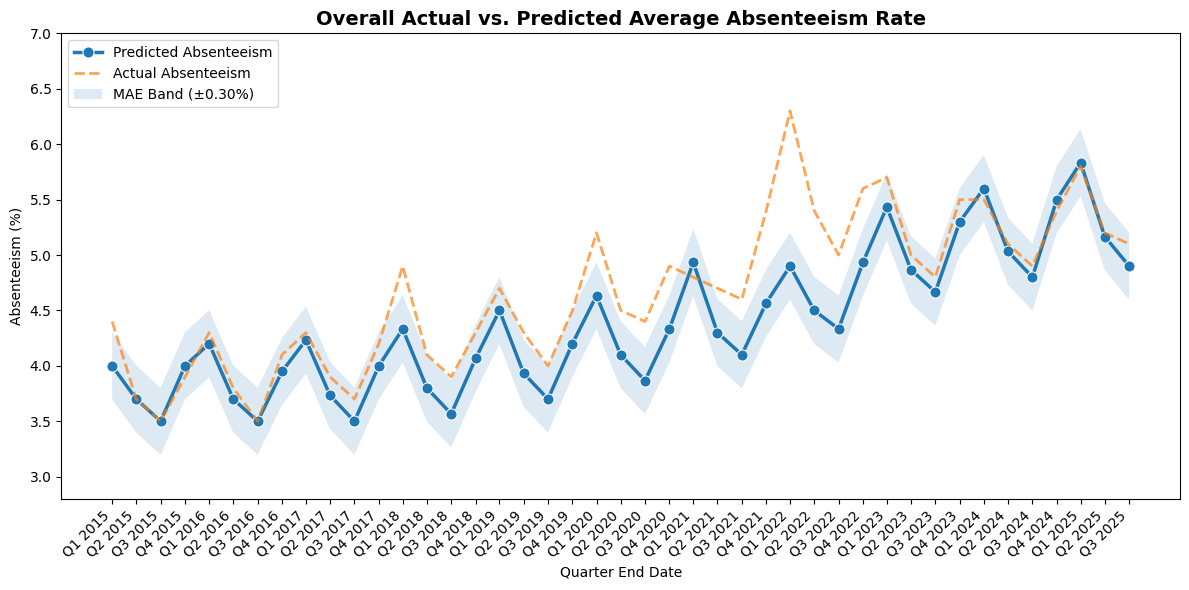

: 

: 

In [ ]:
#Viz code for totals
# 1. Prepare the figure
fig, ax = plt.subplots(figsize=(12, 6))

# 2. Plot Predicted Absenteeism (Primary Line with Markers)
sns.lineplot(
    data=df_plot_total, 
    x="period_enddate", 
    y="baseline_prediction",
    label="Predicted Absenteeism",
    marker="o", 
    errorbar=None,
    ax=ax,
    color="tab:blue",
    linewidth=2.5,
    markersize=8
)

# 3. Plot Actual Absenteeism (Reference Line - No Markers)
sns.lineplot(
    data=df_plot_total, 
    x="period_enddate", 
    y="absenteeism_perc",
    label="Actual Absenteeism",
    marker=None,        # Explicitly remove markers
    errorbar=None,
    ax=ax,
    color="tab:orange",
    linewidth=2,
    linestyle="--",     # Dashed line helps distinguish it as a reference
    alpha=0.7           # Slightly faded to keep focus on predictions
)

# # 4. Calculate means and annotate markers ONLY for the Predicted line
# df_means = df_plot_total.groupby("period_enddate")["baseline_prediction"].mean().reset_index()

# for _, row in df_means.iterrows():
#     ax.annotate(
#         text=f"{row['baseline_prediction']:.1f}%",
#         xy=(row["period_enddate"], row["baseline_prediction"]),
#         xytext=(0, 12),
#         textcoords="offset points",
#         ha="center",
#         va="bottom",
#         fontsize=9,
#         fontweight="bold",
#         color="tab:blue"
#     )

#5. Adding MAE Bandwith
# Get the unique x-axis values and the average predictions for the band
# We sort by date to ensure the 'fill' connects correctly
df_band = df_plot_total.groupby("period_enddate")["baseline_prediction"].mean().reset_index()

# Create the shaded area
ax.fill_between(
    df_band["period_enddate"],
    df_band["baseline_prediction"] - total_mae,
    df_band["baseline_prediction"] + total_mae,
    color="tab:blue",
    alpha=0.15,          # Light transparency
    label=f"MAE Band (±{total_mae:.2f}%)",
    edgecolor="none"     # Removes the hard line around the band
)
# 5. Final Formatting
ax.set_title("Overall Actual vs. Predicted Average Absenteeism Rate", fontsize=14, fontweight="bold")
ax.set_xlabel("Quarter End Date")
ax.set_ylabel("Absenteeism (%)")

# Ensure x-axis ticks match the data points
unique_dates = sorted(df_plot_total["period_enddate"].unique())
tick_labels = [f"Q{((d.month - 1) // 3) + 1} {d.year}" for d in unique_dates]

ax.set_xticks(unique_dates)
ax.set_xticklabels(tick_labels, rotation=45, ha="right")

# Adjust limits for headroom
ax.set_ylim(df_plot_total["absenteeism_perc"].min() * 0.8, df_plot_total["baseline_prediction"].max() * 1.2)

ax.legend(loc="upper left", frameon=True)
plt.tight_layout()
plt.show()

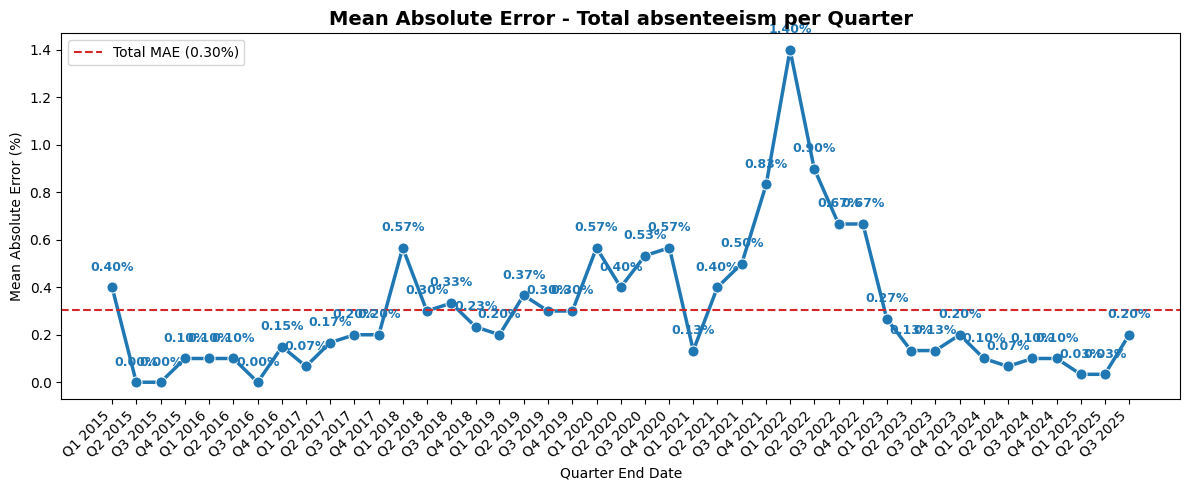

: 

: 

In [ ]:
#Viz code for total MAE per quarter
fig, ax = plt.subplots(figsize=(12, 5))

sns.lineplot(
    data=df_plot_total,
    x="period_enddate",
    y="abs_error",
    marker="o",
    color="tab:blue",
    linewidth=2.5,
    markersize=8,
    ax=ax
)

# Annotate each point
for _, row in df_plot_total.iterrows():
    ax.annotate(
        text=f"{row['abs_error']:.2f}%",
        xy=(row["period_enddate"], row["abs_error"]),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center",
        fontsize=9,
        fontweight="bold",
        color="tab:blue"
    )

# Add global MAE as a reference line
ax.axhline(total_mae, color="tab:red", linestyle="--", linewidth=1.5, label=f"Total MAE ({total_mae:.2f}%)")

unique_dates = sorted(df_plot_total["period_enddate"].unique())
tick_labels = [f"Q{((d.month - 1) // 3) + 1} {d.year}" for d in unique_dates]
ax.set_xticks(unique_dates)
ax.set_xticklabels(tick_labels, rotation=45, ha="right")

ax.set_title("Mean Absolute Error - Total absenteeism per Quarter", fontsize=14, fontweight="bold")
ax.set_xlabel("Quarter End Date")
ax.set_ylabel("Mean Absolute Error (%)")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

**Step 3: Plot the Time Series per SBI code**<br>
First chart shows the MAE per SBI Code (very crowded graph, need to fix that)
Below this are charts per SBI code that show prediction vs. actual.

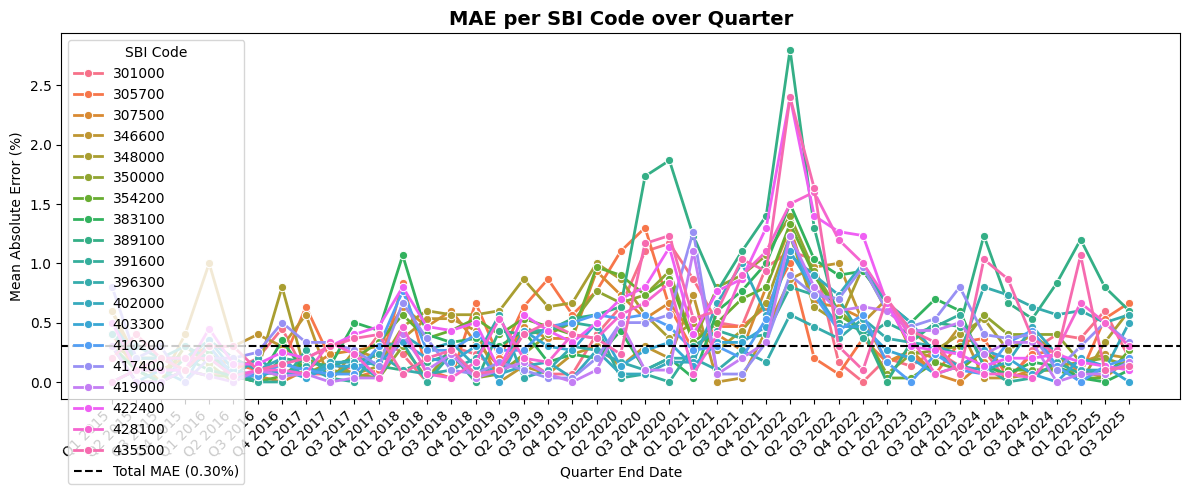

: 

: 

In [ ]:
#Viz code for MAE per SBI code over quarter
fig, ax = plt.subplots(figsize=(12, 5))

sns.lineplot(
    data=df_plot_sbi,
    x="period_enddate",
    y="abs_error",
    hue="sbi_code",
    marker="o",
    linewidth=2,
    markersize=6,
    errorbar=None,
    ax=ax
)

# Add global MAE as a reference line
ax.axhline(total_mae, color="black", linestyle="--", linewidth=1.5, label=f"Total MAE ({total_mae:.2f}%)")

unique_dates = sorted(df_plot_sbi["period_enddate"].unique())
tick_labels = [f"Q{((d.month - 1) // 3) + 1} {d.year}" for d in unique_dates]
ax.set_xticks(unique_dates)
ax.set_xticklabels(tick_labels, rotation=45, ha="right")

ax.set_title("MAE per SBI Code over Quarter", fontsize=14, fontweight="bold")
ax.set_xlabel("Quarter End Date")
ax.set_ylabel("Mean Absolute Error (%)")
ax.legend(loc="upper left", title="SBI Code")
plt.tight_layout()
plt.show()

#### Visuals per SBI code

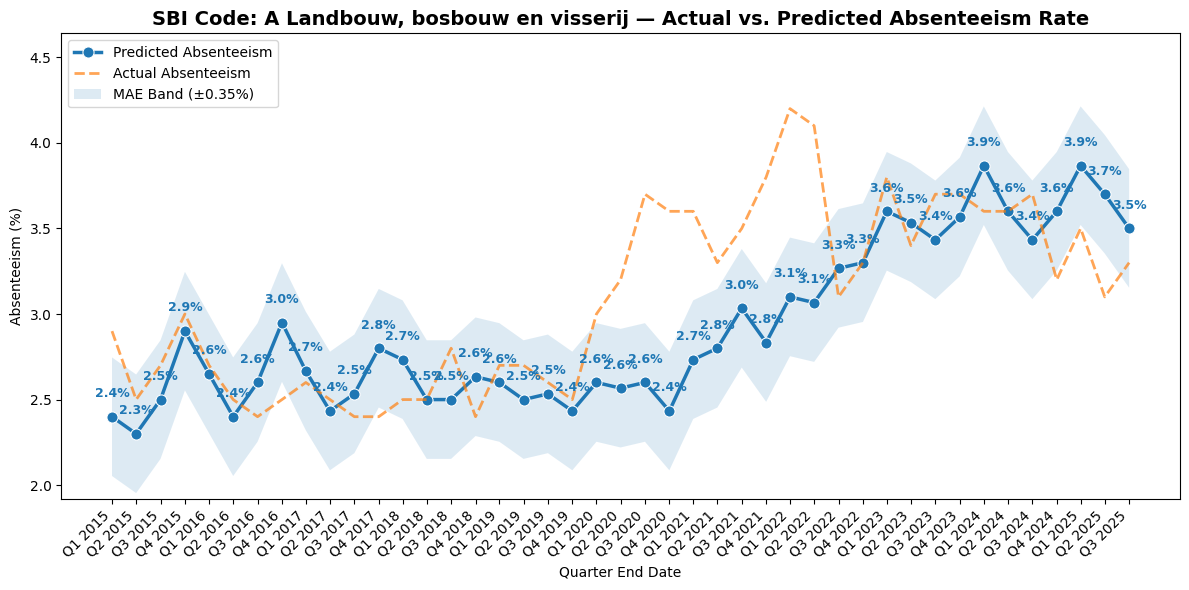

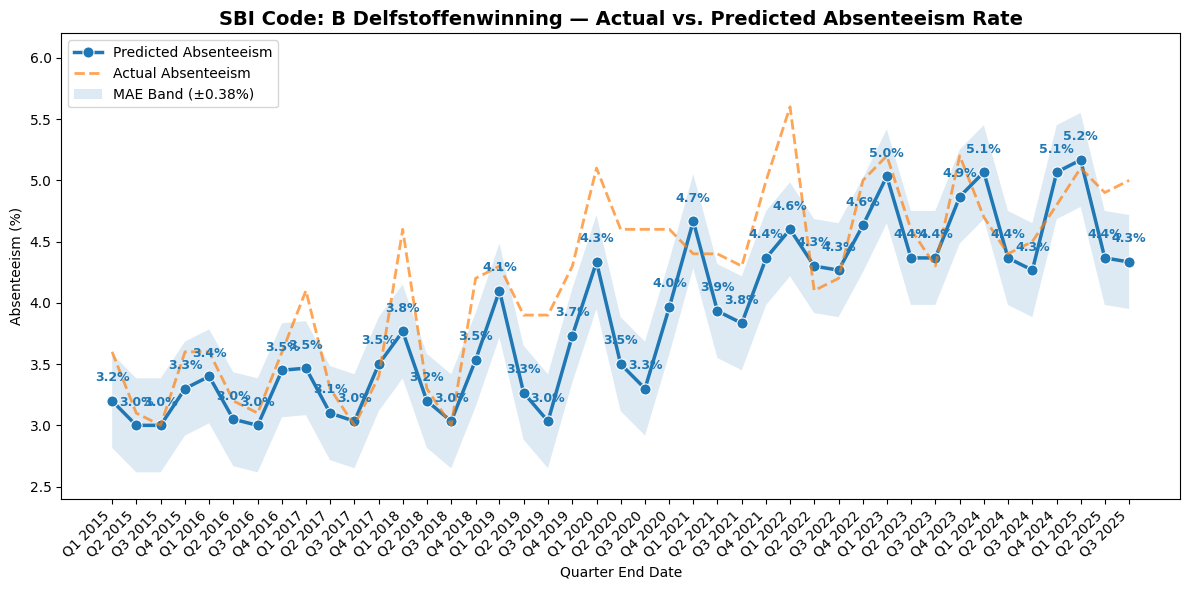

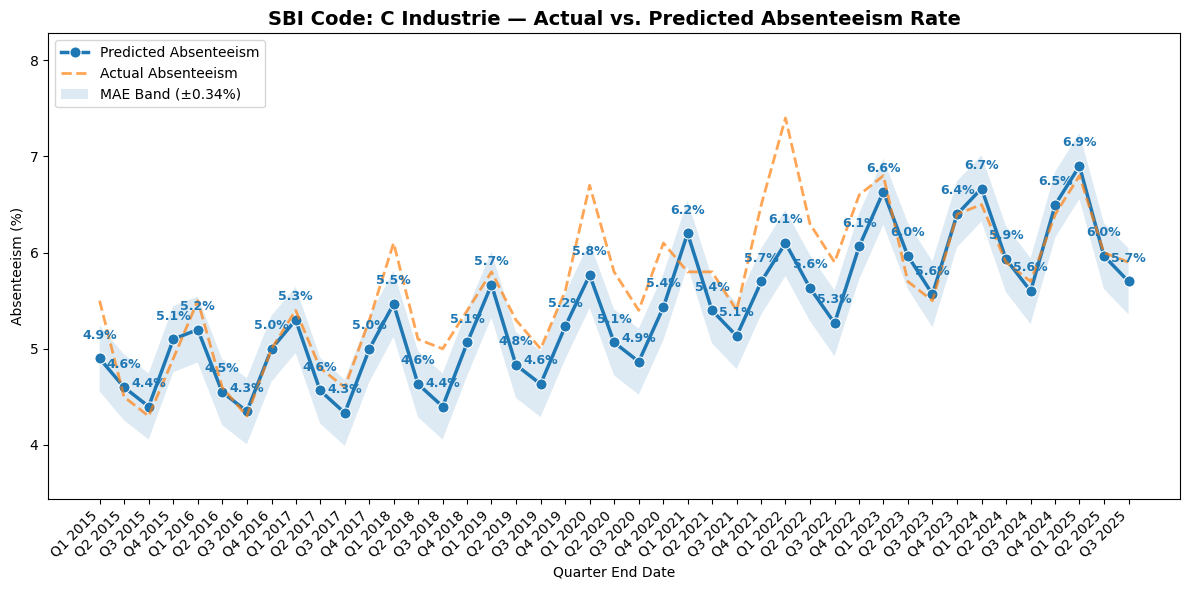

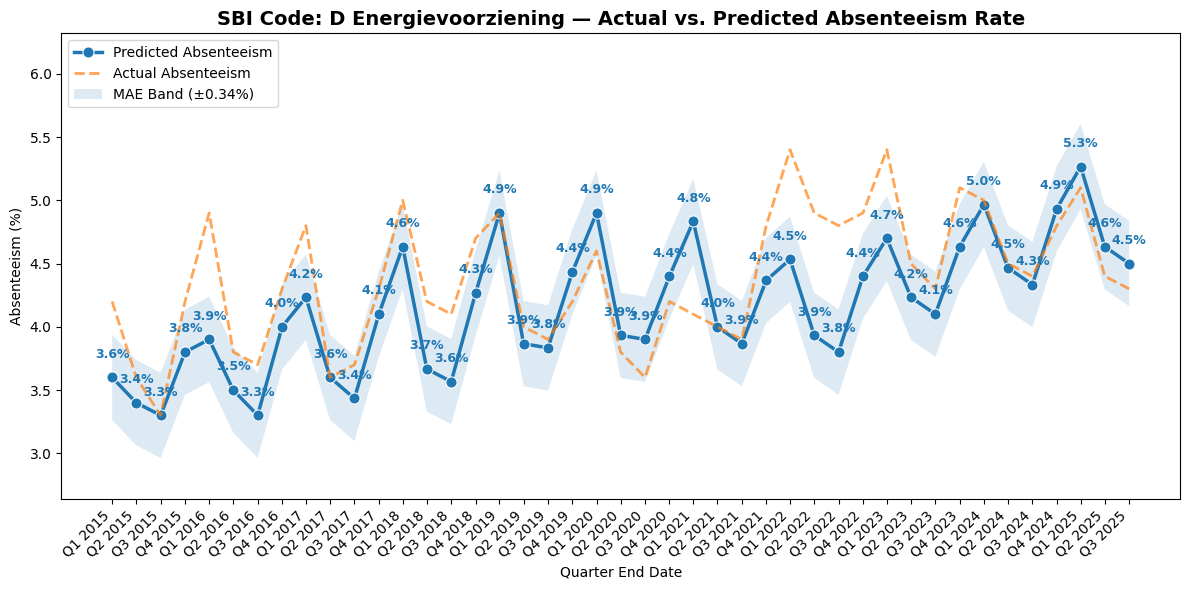

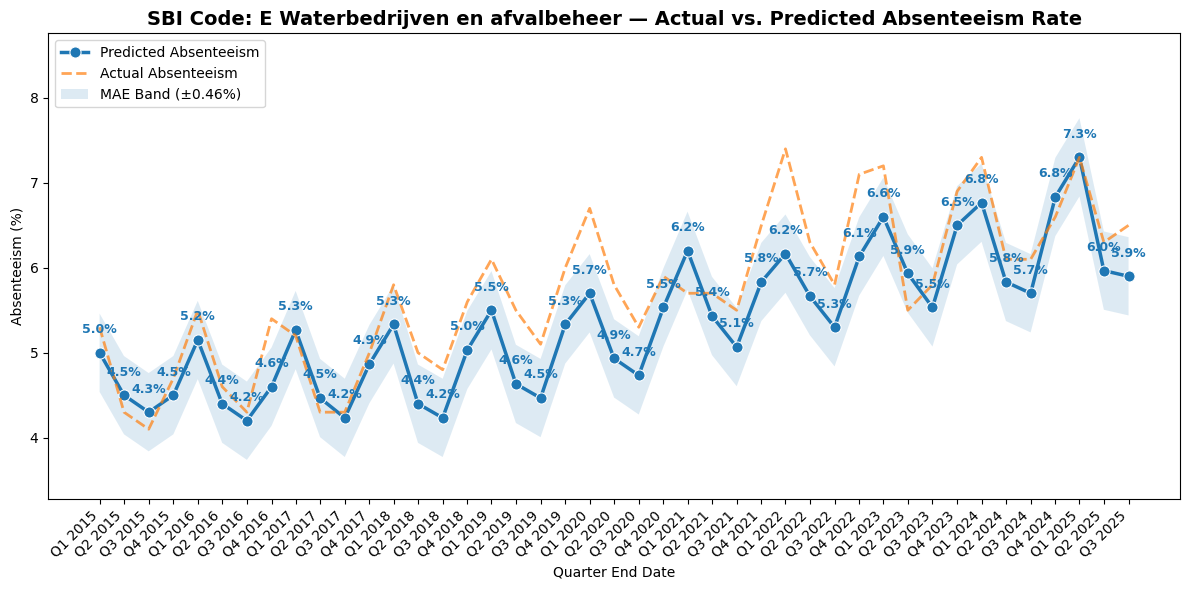

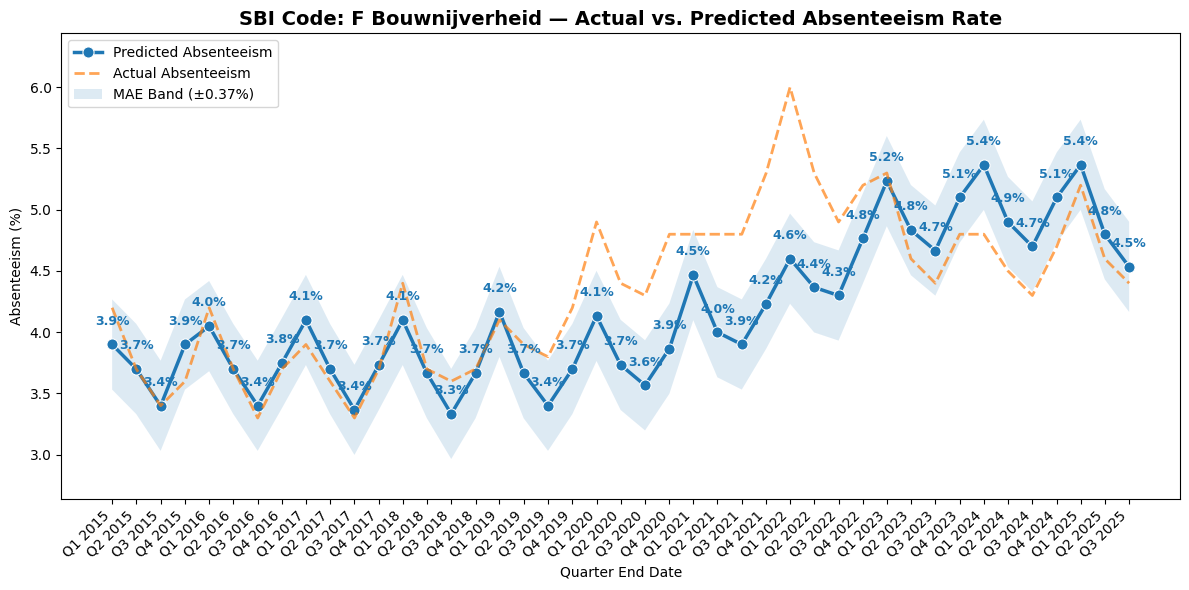

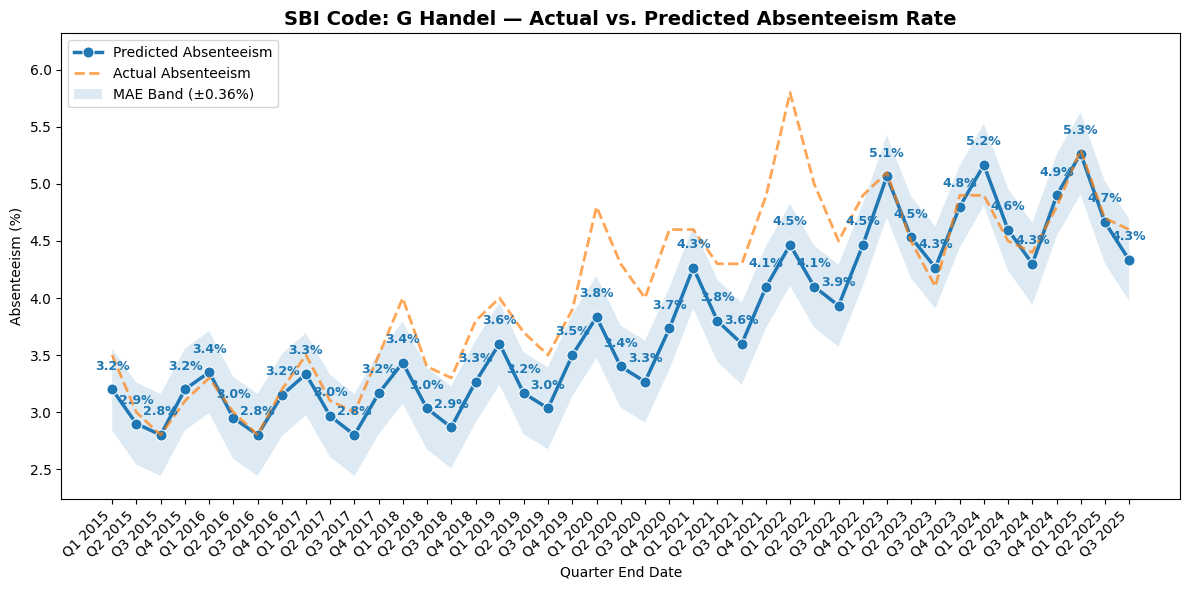

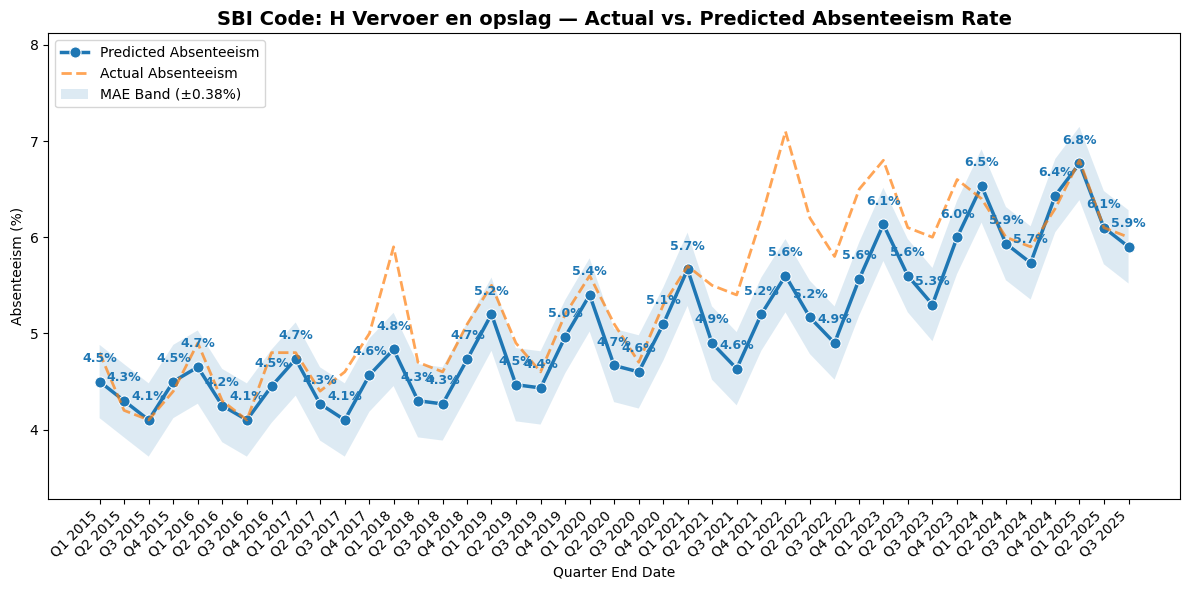

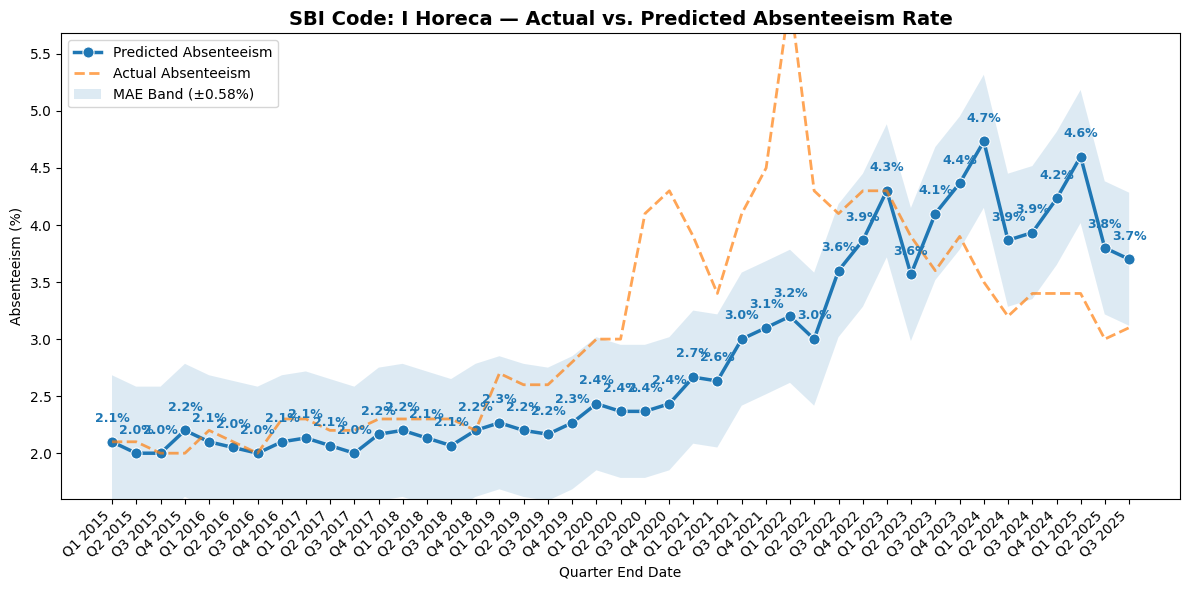

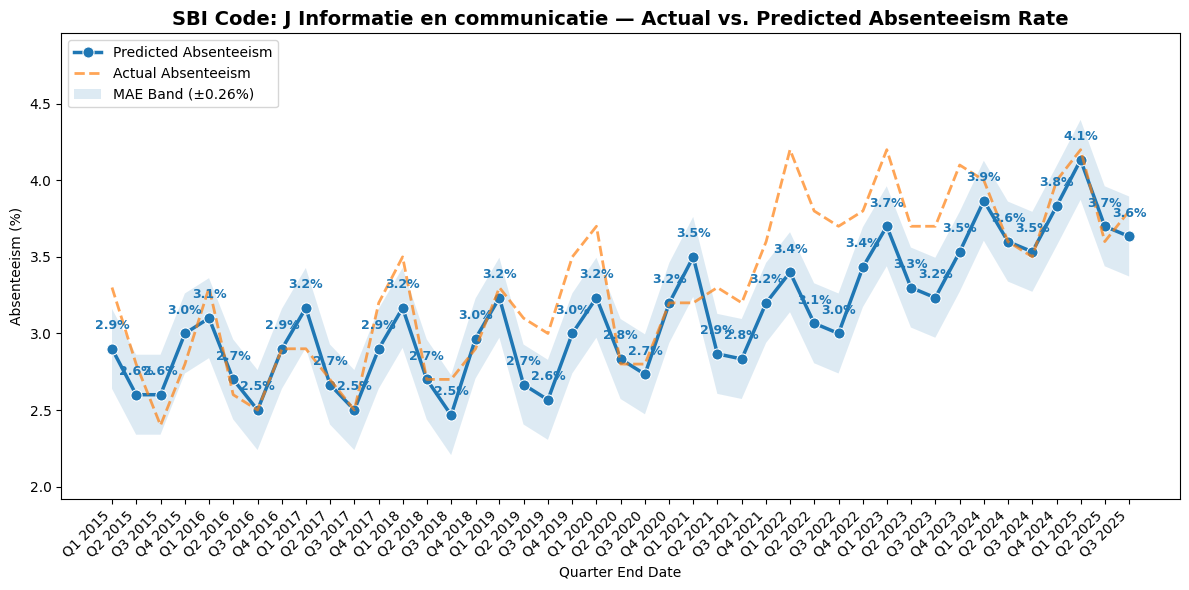

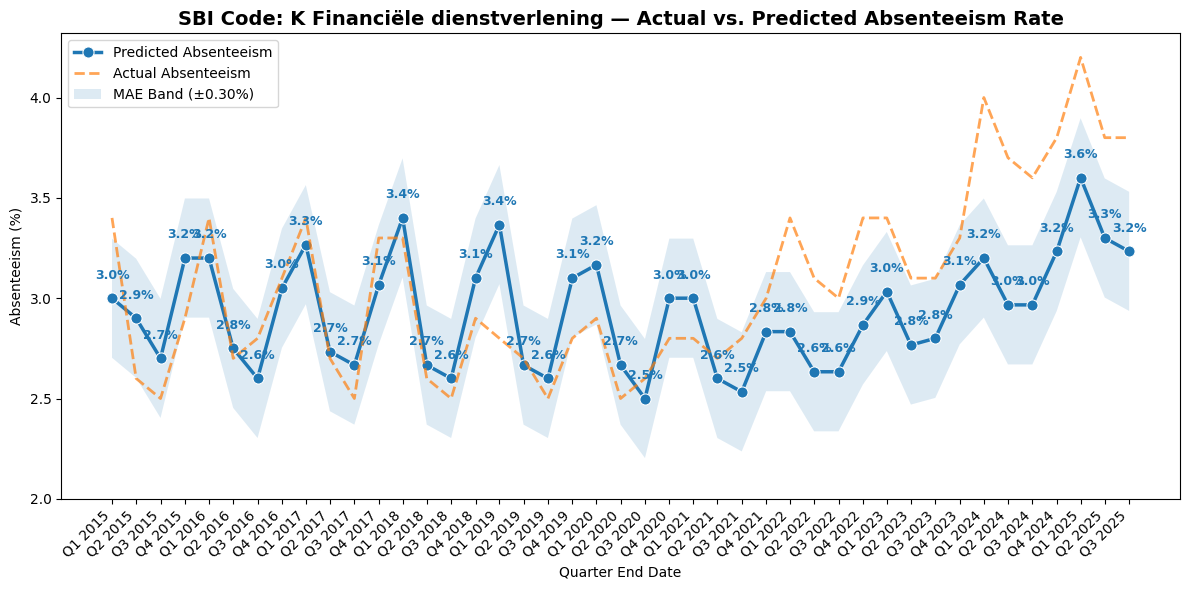

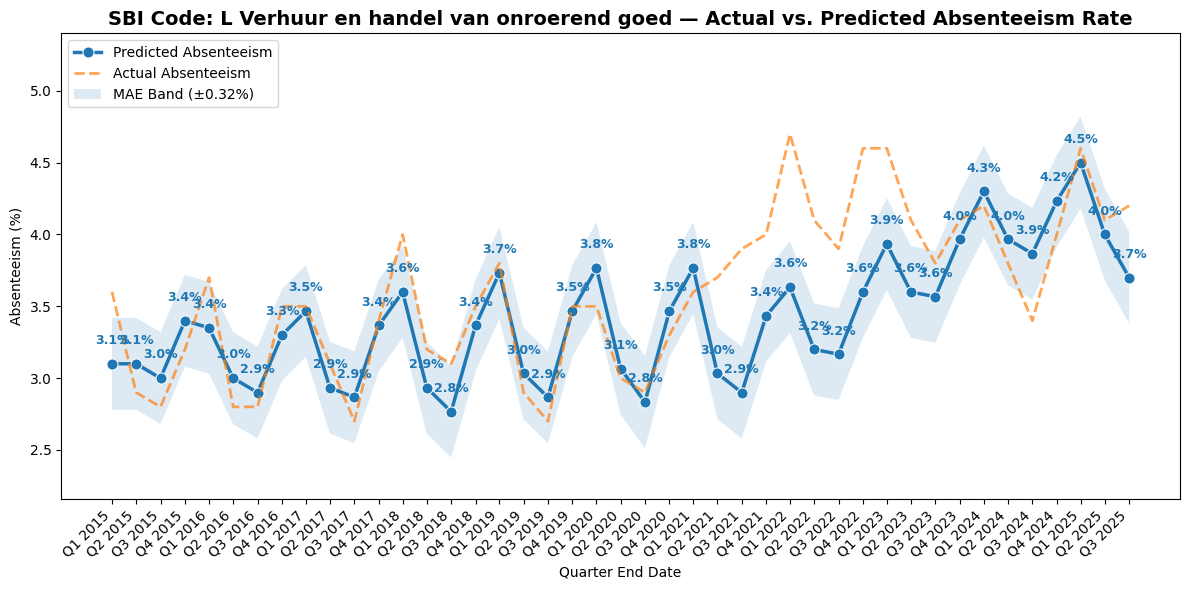

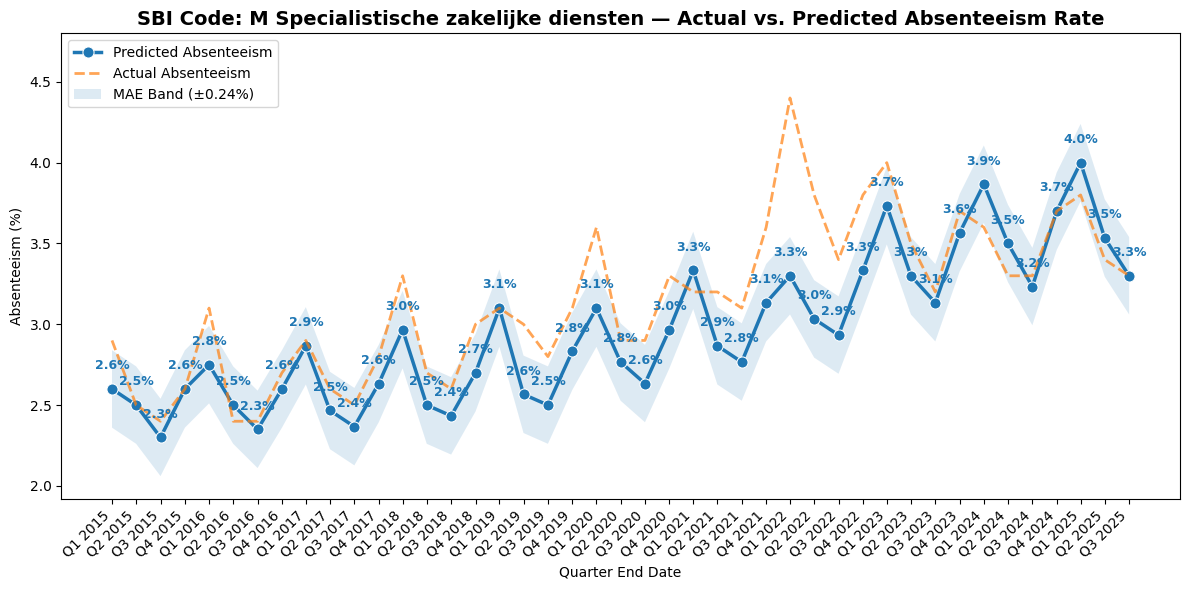

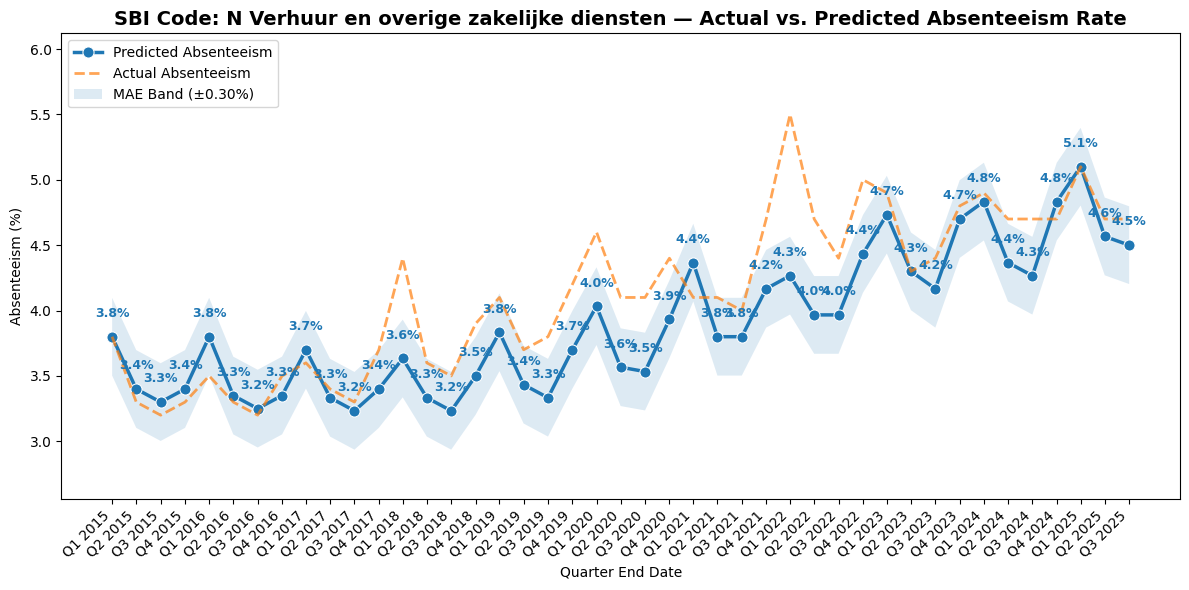

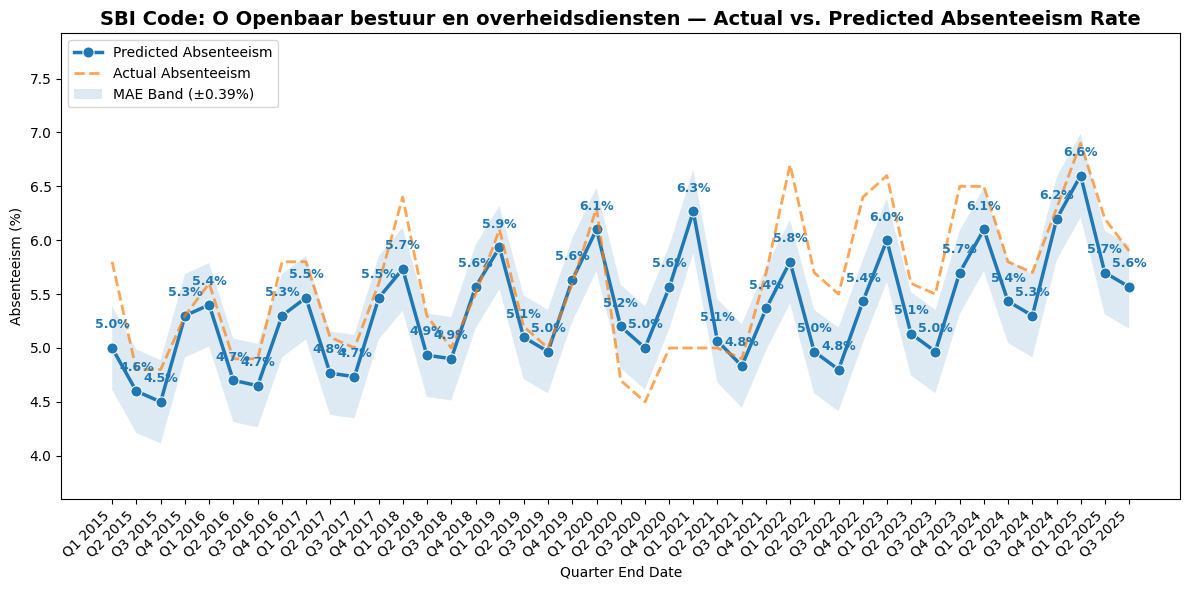

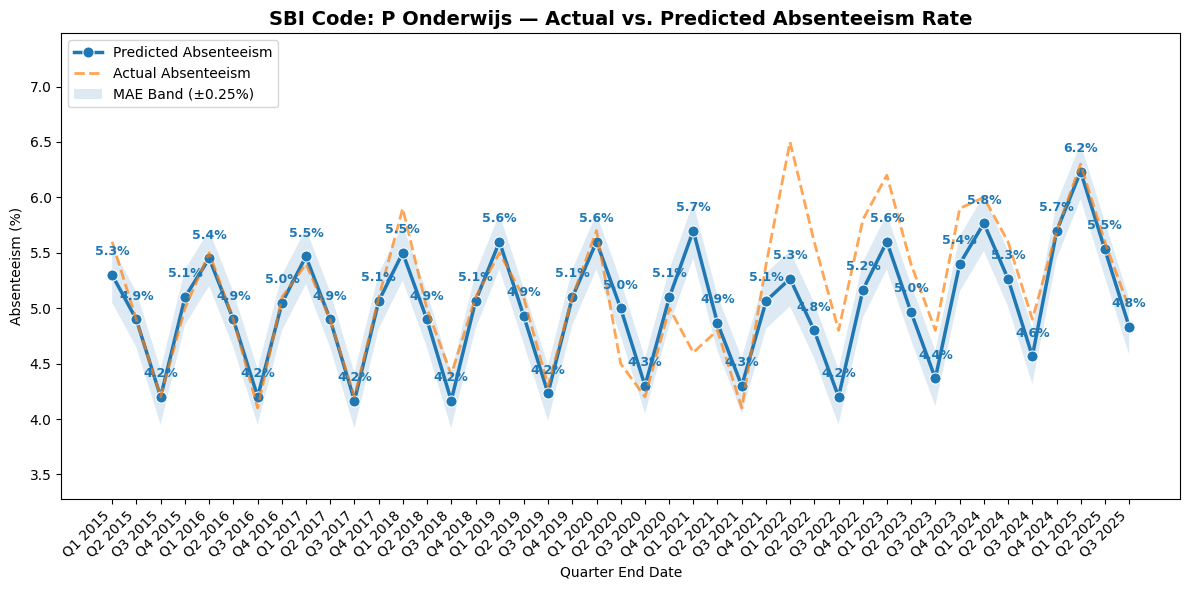

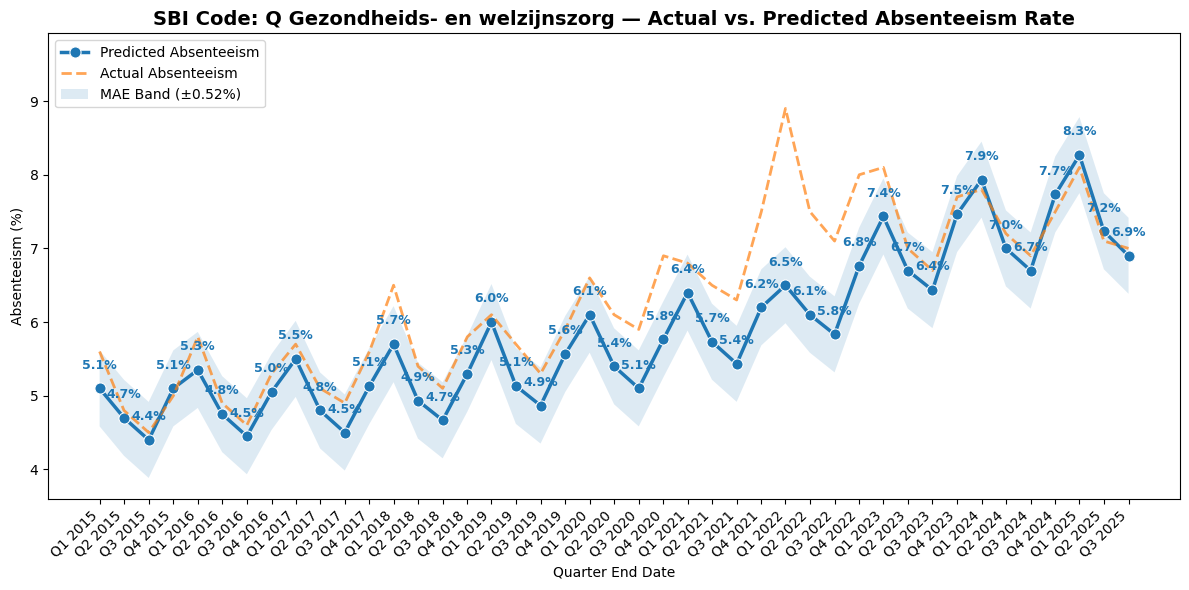

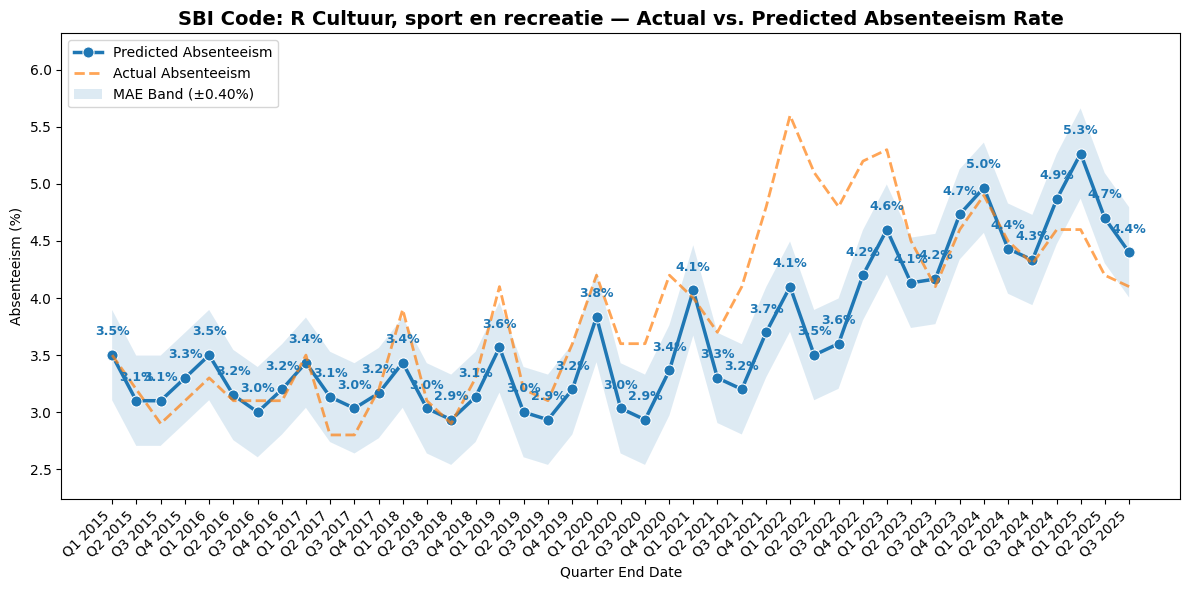

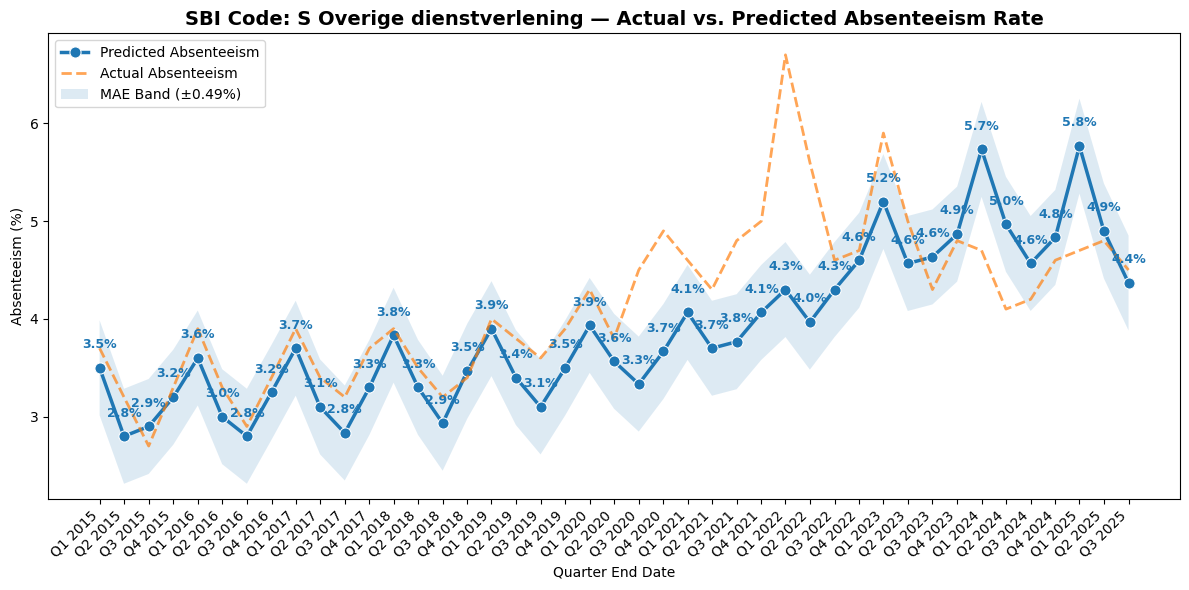

: 

: 

In [ ]:
#Viz code for Actual vs Predicted per SBI code with MAE bandwidth
sbi_codes = sorted(df_plot_sbi["sbi_code"].unique())

for sbi_code in sbi_codes:
    # Filter df_plot_sbi to only the rows for the current SBI code in the loop iteration.
    # .copy() prevents Pandas SettingWithCopyWarning when modifying df_sbi later.
    # .reset_index() resets the index to 0,1,2,... after filtering to avoid index gaps.
    df_sbi = df_plot_sbi[df_plot_sbi["sbi_code"] == sbi_code].copy().reset_index(drop=True)    
    # Look up the MAE for the current SBI code from the precomputed dictionary.
    # The second argument (0) is the default value if the sbi_code is not found in the dict.
    mae = mae_dict_sbi.get(sbi_code, 0)    
    # Extract the human-readable industry title for the current SBI code from the first row with iloc[0].
    sbi_title = df_sbi["sbi_title"].iloc[0]
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # 1. Plot Predicted Absenteeism
    sns.lineplot(
        data=df_sbi,
        x="period_enddate",
        y="baseline_prediction",
        label="Predicted Absenteeism",
        marker="o",
        errorbar=None,
        ax=ax,
        color="tab:blue",
        linewidth=2.5,
        markersize=8
    )

    # 2. Plot Actual Absenteeism
    sns.lineplot(
        data=df_sbi,
        x="period_enddate",
        y="absenteeism_perc",
        label="Actual Absenteeism",
        marker=None,
        errorbar=None,
        ax=ax,
        color="tab:orange",
        linewidth=2,
        linestyle="--",
        alpha=0.7
    )

    # 3. Annotate markers for Predicted line
    for _, row in df_sbi.iterrows():
        ax.annotate(
            text=f"{row['baseline_prediction']:.1f}%",
            xy=(row["period_enddate"], row["baseline_prediction"]),
            xytext=(0, 12),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
            color="tab:blue"
        )

    # 4. MAE Bandwidth
    df_band = df_sbi.sort_values("period_enddate")

    ax.fill_between(
        df_band["period_enddate"],
        df_band["baseline_prediction"] - mae,
        df_band["baseline_prediction"] + mae,
        color="tab:blue",
        alpha=0.15,
        label=f"MAE Band (±{mae:.2f}%)",
        edgecolor="none"
    )

    # 5. Formatting
    ax.set_title(
        f"SBI Code: {sbi_title} — Actual vs. Predicted Absenteeism Rate",
        fontsize=14,
        fontweight="bold"
    )
    ax.set_xlabel("Quarter End Date")
    ax.set_ylabel("Absenteeism (%)")

    unique_dates = sorted(df_sbi["period_enddate"].unique())
    tick_labels = [f"Q{((d.month - 1) // 3) + 1} {d.year}" for d in unique_dates]

    ax.set_xticks(unique_dates)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right")

    ax.set_ylim(df_sbi["absenteeism_perc"].min() * 0.8, df_sbi["baseline_prediction"].max() * 1.2)

    ax.legend(loc="upper left", frameon=True)
    plt.tight_layout()
    plt.show()

#### Visuals per Company size

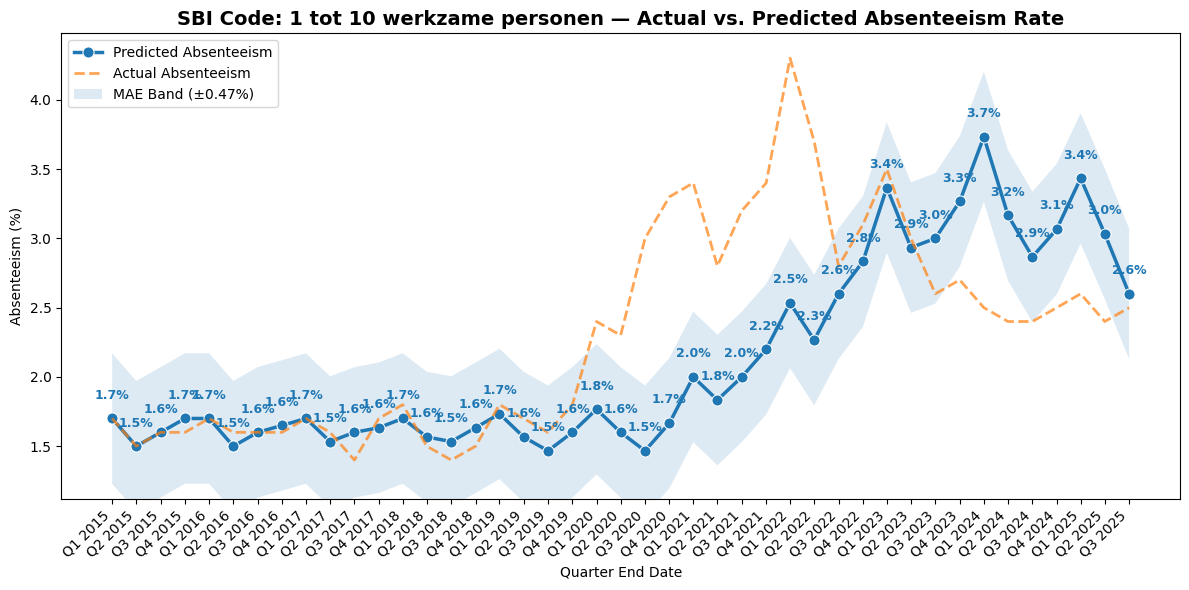

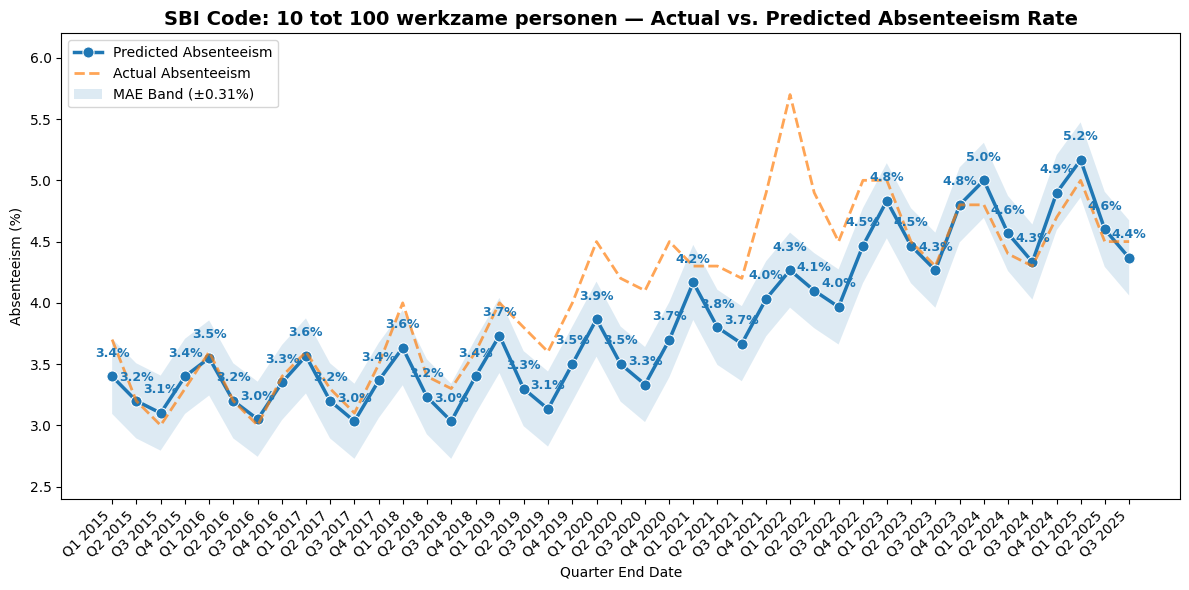

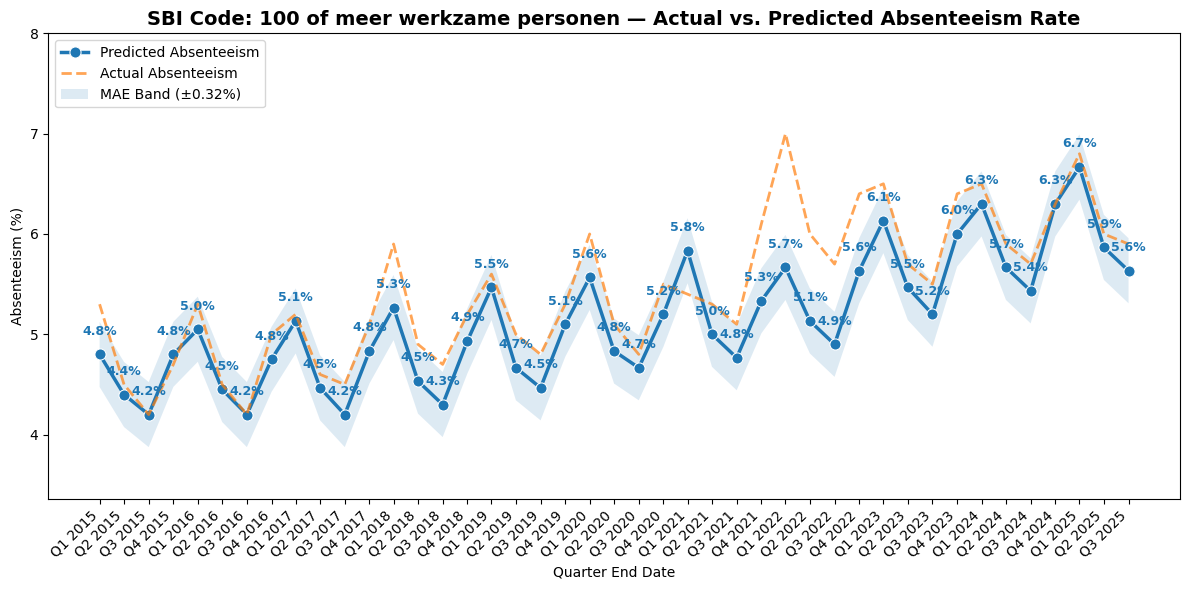

: 

: 

In [ ]:
#Viz code for Actual vs Predicted per SBI code with MAE bandwidth
sbi_codes = sorted(df_plot_compsize["sbi_code"].unique())

for sbi_code in sbi_codes:    
    df_sbi = df_plot_compsize[df_plot_compsize["sbi_code"] == sbi_code].copy().reset_index(drop=True)    
    mae = mae_dict_compsize.get(sbi_code, 0)    
    sbi_title = df_sbi["sbi_title"].iloc[0]
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # 1. Plot Predicted Absenteeism
    sns.lineplot(
        data=df_sbi,
        x="period_enddate",
        y="baseline_prediction",
        label="Predicted Absenteeism",
        marker="o",
        errorbar=None,
        ax=ax,
        color="tab:blue",
        linewidth=2.5,
        markersize=8
    )

    # 2. Plot Actual Absenteeism
    sns.lineplot(
        data=df_sbi,
        x="period_enddate",
        y="absenteeism_perc",
        label="Actual Absenteeism",
        marker=None,
        errorbar=None,
        ax=ax,
        color="tab:orange",
        linewidth=2,
        linestyle="--",
        alpha=0.7
    )

    # 3. Annotate markers for Predicted line
    for _, row in df_sbi.iterrows():
        ax.annotate(
            text=f"{row['baseline_prediction']:.1f}%",
            xy=(row["period_enddate"], row["baseline_prediction"]),
            xytext=(0, 12),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
            color="tab:blue"
        )

    # 4. MAE Bandwidth
    df_band = df_sbi.sort_values("period_enddate")

    ax.fill_between(
        df_band["period_enddate"],
        df_band["baseline_prediction"] - mae,
        df_band["baseline_prediction"] + mae,
        color="tab:blue",
        alpha=0.15,
        label=f"MAE Band (±{mae:.2f}%)",
        edgecolor="none"
    )

    # 5. Formatting
    ax.set_title(
        f"SBI Code: {sbi_title} — Actual vs. Predicted Absenteeism Rate",
        fontsize=14,
        fontweight="bold"
    )
    ax.set_xlabel("Quarter End Date")
    ax.set_ylabel("Absenteeism (%)")

    unique_dates = sorted(df_sbi["period_enddate"].unique())
    tick_labels = [f"Q{((d.month - 1) // 3) + 1} {d.year}" for d in unique_dates]

    ax.set_xticks(unique_dates)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right")

    ax.set_ylim(df_sbi["absenteeism_perc"].min() * 0.8, df_sbi["baseline_prediction"].max() * 1.2)

    ax.legend(loc="upper left", frameon=True)
    plt.tight_layout()
    plt.show()